# notMNIST
- You can find my repository on notMNIST <a href="https://github.com/AmmarRashed/notMNIST">here</a>

In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], raw_labels.flatten()
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    raw_labels.flatten()
        

In [8]:
learning_rate = 0.05
batch_size = 1000
h_size = 128

In [16]:
graph = tf.Graph()
is_training = True
with graph.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        rnn_cell = tf.contrib.rnn.BasicRNNCell(h_size)
        
        if is_training:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, input_keep_prob=0.5)
            
        outputs, states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)
    
        logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [17]:
def run_session(graph, epochs, learning_rate, batch_size):
    start = time.time()
    accuracies = dict()
    losses = dict()
    batches = generate_batch(batch_size=batch_size)

    with tf.device("/gpu"), tf.Session(graph=graph) as sess:
        init.run()
        print("Variables initialized")
        average_loss = 0
        for e in range(epochs+1):
            batch_X, batch_y = batches.__next__()
            feed_dict = {x:batch_X, y:batch_y}
            is_training = True
            _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
            average_loss += np.mean(loss)
#                 if e%50 == 0:
            if e%10 == 0:
                print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/10 if e>0 else average_loss))
            losses[e] = average_loss
            average_loss = 0
            is_training = False
            accuracy_ = sess.run([accuracy], feed_dict={x:test_X, y:test_y})
            accuracy_ = np.mean(accuracy_)
            accuracies[e] = accuracy_
            if e%10 == 0:
                print("Accuracy:{0}".format(accuracy_))
                print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(accuracies.keys())
    data1 = [accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [18]:
test_X = test_X.reshape(-1, image_size, image_size)
train_X = train_X.reshape(-1, image_size, image_size)
test_X.shape, train_X.shape

((18724, 28, 28), (529114, 28, 28))

Variables initialized
Epoch 0
Cross-entropy loss: 2.5180153846740723
Accuracy:0.11872462928295135
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10
Cross-entropy loss: 0.20288798809051514
Accuracy:0.3021790087223053
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20
Cross-entropy loss: 0.18394969701766967
Accuracy:0.38736382126808167
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30
Cross-entropy loss: 0.1710672378540039
Accuracy:0.4522537887096405
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40
Cross-entropy loss: 0.15437638759613037
Accuracy:0.5435804128646851
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.1455731511116028
Accuracy:0.59693443775177
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60
Cross-entropy loss: 0.14159377813339233
Accuracy:0.6348002552986145
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 70
Cross-entropy loss: 0.1374009370803833
Accuracy:0.6531189680099487
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 80
Cross-entropy loss: 0.13411254

Epoch 690
Cross-entropy loss: 0.07824947237968445
Accuracy:0.8563874959945679
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.08192514777183532
Accuracy:0.8547319173812866
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 710
Cross-entropy loss: 0.07776212096214294
Accuracy:0.8420209288597107
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 720
Cross-entropy loss: 0.07558292746543885
Accuracy:0.8291497826576233
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 730
Cross-entropy loss: 0.07440372705459594
Accuracy:0.8550523519515991
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 740
Cross-entropy loss: 0.07896443009376526
Accuracy:0.844691276550293
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 750
Cross-entropy loss: 0.07279698252677917
Accuracy:0.8373211026191711
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 760
Cross-entropy loss: 0.0720718502998352
Accuracy:0.8418607115745544
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 770
Cross-entropy loss: 0.07797970175743103


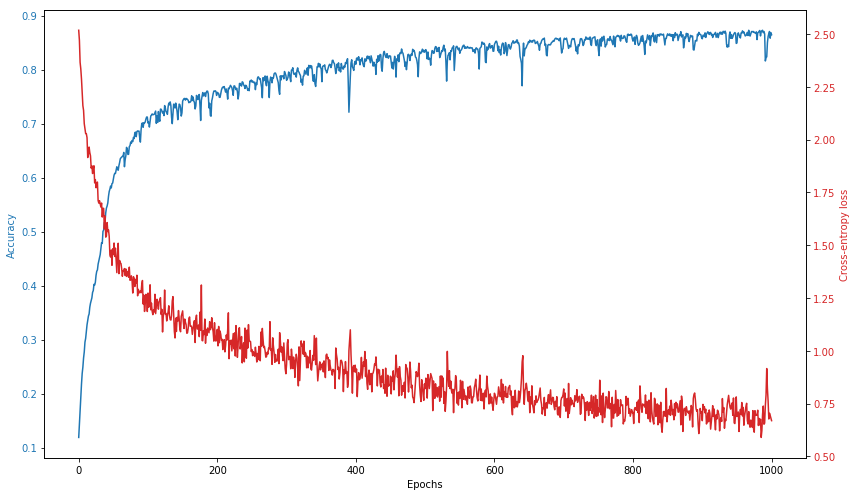

In [19]:
epochs = 1000
run_session(graph, epochs, learning_rate, batch_size)

### Using `LSTMCell`
<img src="https://github.com/AmmarRashed/notMNIST/blob/master/misc/lstm_diagram.png?raw=true">

In [22]:
graph_lstm = tf.Graph()
is_training = True
with graph_lstm.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        lstm_cell = tf.contrib.rnn.LSTMCell(h_size)
        
        if is_training:
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=0.5)
            
        outputs, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
    
        top_layer_h_state = states[-1]
        logits = tf.layers.dense(top_layer_h_state, nclasses, name="softmax")
        
#         logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Variables initialized
Epoch 0
Cross-entropy loss: 2.3477869033813477
Accuracy:0.10670796781778336
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10
Cross-entropy loss: 0.21799273490905763
Accuracy:0.28316599130630493
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20
Cross-entropy loss: 0.20535888671875
Accuracy:0.37347787618637085
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30
Cross-entropy loss: 0.1956902861595154
Accuracy:0.43388164043426514
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40
Cross-entropy loss: 0.18810274600982665
Accuracy:0.48509934544563293
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.17737207412719727
Accuracy:0.5339670777320862
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60
Cross-entropy loss: 0.17260066270828248
Accuracy:0.5776543617248535
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 70
Cross-entropy loss: 0.16577504873275756
Accuracy:0.6151997447013855
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 80
Cross-entropy loss: 0.1589

Epoch 690
Cross-entropy loss: 0.07681103944778442
Accuracy:0.863650918006897
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.07681785821914673
Accuracy:0.8635975122451782
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 710
Cross-entropy loss: 0.0693630337715149
Accuracy:0.8616214394569397
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 720
Cross-entropy loss: 0.06883919835090638
Accuracy:0.8648259043693542
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 730
Cross-entropy loss: 0.0716054916381836
Accuracy:0.8666417598724365
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 740
Cross-entropy loss: 0.07317956686019897
Accuracy:0.866321325302124
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 750
Cross-entropy loss: 0.07099694013595581
Accuracy:0.8645054697990417
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 760
Cross-entropy loss: 0.0659454882144928
Accuracy:0.8662679195404053
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 770
Cross-entropy loss: 0.07151588201522827
Acc

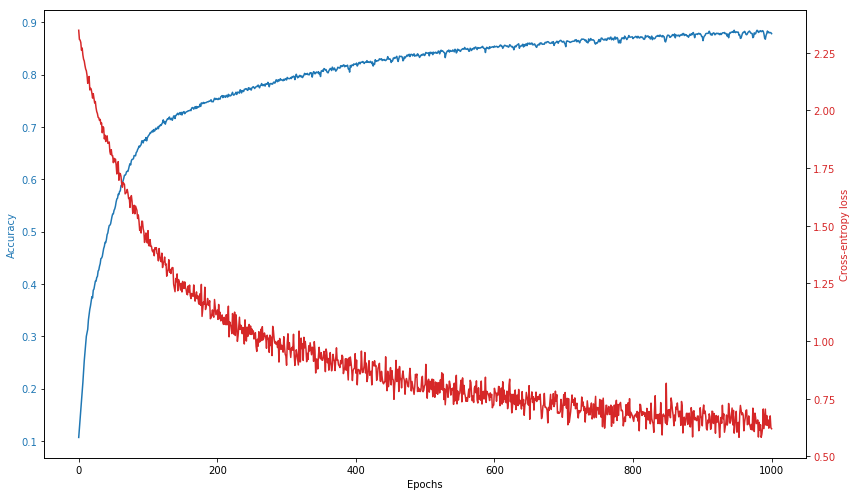

In [23]:
run_session(graph_lstm, epochs, learning_rate, batch_size)

### Using multiple `GRUCell`s

In [24]:
graph_gru = tf.Graph()
n_layers = 3

is_training = True
with graph_gru.as_default():
    with tf.name_scope("inputs"):
        x = tf.placeholder(tf.float32, shape=[None, image_size, image_size])
        y = tf.placeholder(tf.int32, shape=[None])
        gru_cells = [tf.contrib.rnn.LSTMCell(h_size) for i in range(n_layers)]
        
        if is_training:
            gru_cells = [tf.contrib.rnn.DropoutWrapper(gru_cell, input_keep_prob=0.5) for gru_cell in gru_cells]
        
        deep_gru = tf.contrib.rnn.MultiRNNCell(gru_cells)
        
        outputs, states = tf.nn.dynamic_rnn(deep_gru, x, dtype=tf.float32)
    
        top_layer_h_state = states[-1][-1]
        logits = tf.layers.dense(top_layer_h_state, nclasses, name="softmax")
        
#         logits = tf.contrib.layers.fully_connected(states, nclasses, activation_fn=None)
        
    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=y))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Accuracy"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Variables initialized
Epoch 0
Cross-entropy loss: 2.292617082595825
Accuracy:0.17175817489624023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10
Cross-entropy loss: 0.22346189022064208
Accuracy:0.2772911787033081
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20
Cross-entropy loss: 0.21743412017822267
Accuracy:0.33668020367622375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30
Cross-entropy loss: 0.2101184368133545
Accuracy:0.3681371510028839
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 40
Cross-entropy loss: 0.20152504444122316
Accuracy:0.39580217003822327
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 50
Cross-entropy loss: 0.19044225215911864
Accuracy:0.41689810156822205
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 60
Cross-entropy loss: 0.1806538462638855
Accuracy:0.4467528164386749
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 70
Cross-entropy loss: 0.17627674341201782
Accuracy:0.4661931097507477
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 80
Cross-entropy loss: 0.1698

Epoch 690
Cross-entropy loss: 0.08396332263946533
Accuracy:0.8336359858512878
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.08355377316474914
Accuracy:0.8439970016479492
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 710
Cross-entropy loss: 0.0742665708065033
Accuracy:0.8465071320533752
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 720
Cross-entropy loss: 0.07203735709190369
Accuracy:0.846346914768219
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 730
Cross-entropy loss: 0.07470788955688476
Accuracy:0.8492843508720398
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 740
Cross-entropy loss: 0.07739328145980835
Accuracy:0.8475219011306763
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 750
Cross-entropy loss: 0.07174142599105834
Accuracy:0.8476287126541138
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 760
Cross-entropy loss: 0.07025537490844727
Accuracy:0.849230945110321
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 770
Cross-entropy loss: 0.0752649188041687
Ac

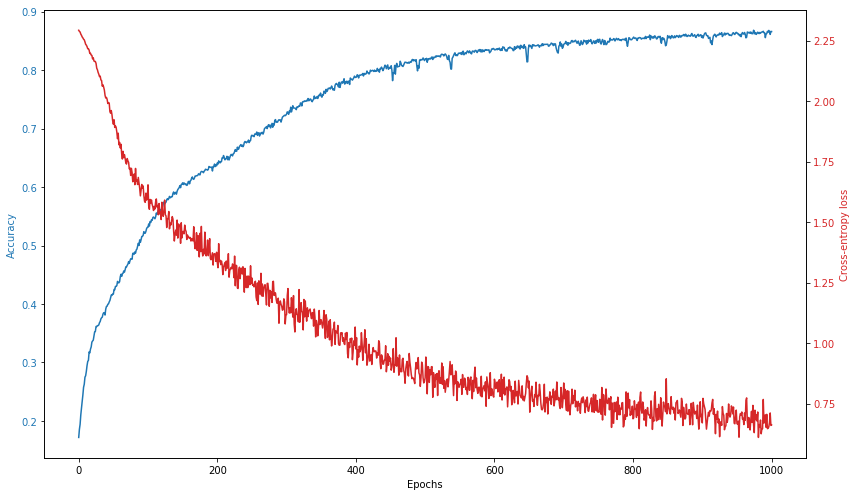

In [25]:
run_session(graph_gru, epochs, learning_rate, batch_size)